<a href="https://colab.research.google.com/github/yunions/renewable/blob/master/univaritate_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import itertools
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams['figure.dpi'] = 100

# pandas max row 
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000

In [5]:
data = pd.read_csv('total_data.csv')
data.columns = ['datetime','solar_result','temp','rain_t','rain_r',
                    'hum','wins', 'wind','sky','altitude','azimuth','altitude_m','azimuth_m']
data['datetime'] = pd.to_datetime(data['datetime'], format = '%Y%m%d%H')
data.index = data['datetime']
data.head()

,datetime,solar_result,temp,rain_t,rain_r,hum,wins,wind,sky,altitude,azimuth,altitude_m,azimuth_m
datetime,,,,,,,,,,,,,
2017-06-01 09:00:00,2017-06-01 09:00:00,33.12,21.000000,0.0,0.0,65.000000,2.400000,111.000000,1.0,44.230000,92.420000,48.617684,96.897301
2017-06-01 10:00:00,2017-06-01 10:00:00,50.16,21.333333,0.0,0.0,65.000000,2.333333,112.000000,1.0,54.833333,114.446667,60.487336,109.600378
2017-06-01 11:00:00,2017-06-01 11:00:00,96.72,21.666667,0.0,0.0,65.000000,2.266667,113.000000,1.0,65.436667,136.473333,71.021213,132.383793
2017-06-01 12:00:00,2017-06-01 12:00:00,120.96,22.000000,0.0,0.0,65.000000,2.200000,114.000000,1.0,76.040000,158.500000,76.252859,180.000000
2017-06-01 13:00:00,2017-06-01 13:00:00,118.80,21.333333,0.0,0.0,63.333333,2.433333,107.666667,1.0,68.386667,192.333333,71.021213,227.616207


# 데이터 전처리

In [6]:
#standardization
mean = data.loc[:'2019-05-31','solar_result'].mean()
std = data.loc[:'2019-05-31','solar_result'].std()
data['solar_reuslt_sc'] = data['solar_result'].apply(lambda x : (x-mean)/std)

In [7]:
## prophet 실행을 위해, y변수인 solar result와, ds인 datetime을 추가
dataset = pd.DataFrame()
dataset['y'] = data['solar_reuslt_sc']
dataset['ds'] = data['datetime']
dataset.head()

,y,ds
datetime,,
2017-06-01 09:00:00,0.108698,2017-06-01 09:00:00
2017-06-01 10:00:00,0.502756,2017-06-01 10:00:00
2017-06-01 11:00:00,1.579476,2017-06-01 11:00:00
2017-06-01 12:00:00,2.140037,2017-06-01 12:00:00
2017-06-01 13:00:00,2.090086,2017-06-01 13:00:00


In [8]:
# 2년 : train / 1년 : test
train = dataset[dataset['ds'] < '2019-06-01']
test = dataset[dataset['ds'] >= '2019-06-01']

In [9]:
test.index[0],train.index[-1]

(Timestamp('2019-06-01 00:00:00'), Timestamp('2019-05-31 23:00:00'))

# Prophet
- prophet의 경우, univaritate time series (일변량 시계열) 분석이므로 solar_result를 제외하고 사용하지 않음
- y : 실제 값
- ds : 시간(datetime)</br>
y, ds 제외 필요한 값이 없는 모델

In [24]:
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly
from fbprophet.plot import add_changepoints_to_plot

## 1.Model and prediction

In [25]:
m = Prophet()
m.fit(train)
future = m.make_future_dataframe(periods=10000, freq='H')
forecast = m.predict(future)
forecast.tail()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
27506,2020-07-21 11:00:00,0.986326,1.696490,3.388645,0.428373,1.622772,1.528814,1.528814,1.528814,1.535310,1.535310,1.535310,-0.006496,-0.006496,-0.006496,0.0,0.0,0.0,2.515140
27507,2020-07-21 12:00:00,0.986405,1.829130,3.559535,0.428397,1.622922,1.683811,1.683811,1.683811,1.690701,1.690701,1.690701,-0.006890,-0.006890,-0.006890,0.0,0.0,0.0,2.670216
27508,2020-07-21 13:00:00,0.986484,1.744183,3.490815,0.428421,1.623072,1.606907,1.606907,1.606907,1.614211,1.614211,1.614211,-0.007304,-0.007304,-0.007304,0.0,0.0,0.0,2.593391
27509,2020-07-21 14:00:00,0.986564,1.449218,3.202485,0.428445,1.623223,1.304666,1.304666,1.304666,1.312397,1.312397,1.312397,-0.007731,-0.007731,-0.007731,0.0,0.0,0.0,2.291230
27510,2020-07-21 15:00:00,0.986643,0.943366,2.767091,0.428469,1.623373,0.820664,0.820664,0.820664,0.828828,0.828828,0.828828,-0.008164,-0.008164,-0.008164,0.0,0.0,0.0,1.807306


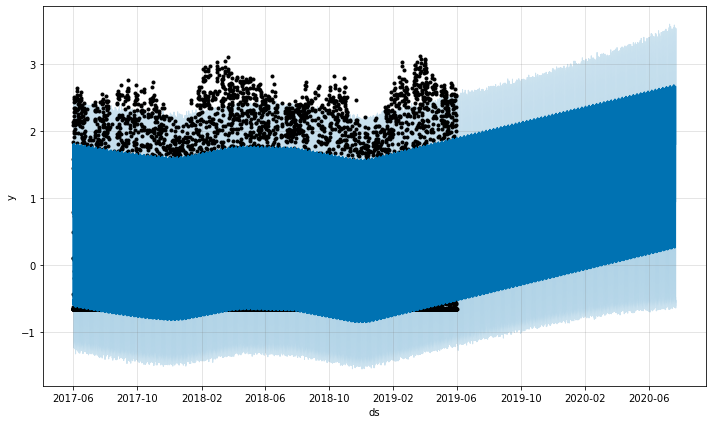

In [34]:
fig1 = m.plot(forecast)

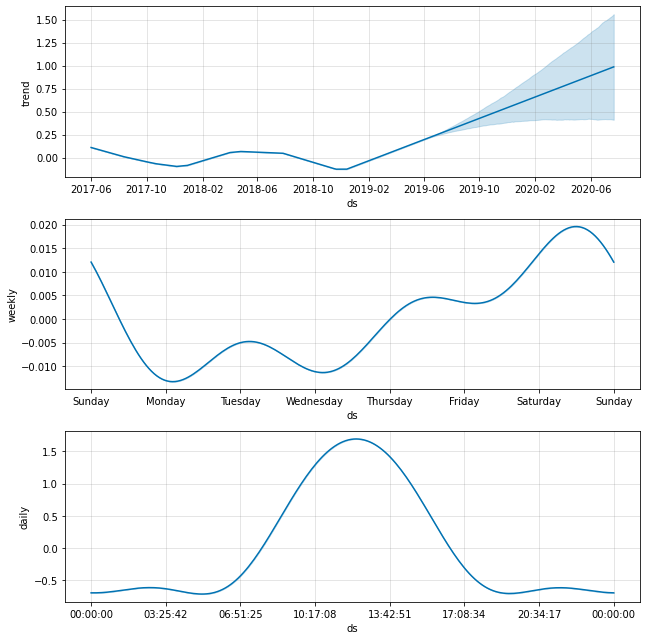

In [35]:
fig = m.plot_components(forecast)

In [26]:
forecast_sub = forecast[['ds', 'yhat']]
forecast_sub['ds'] = forecast_sub['ds']
test_sub = test[['ds', 'y']]
eval_df = test_sub.merge(forecast_sub, on=['ds'], how='left')
eval_df['abs_error'] = abs(eval_df['y']-eval_df['yhat'])
eval_df['hourly_FA'] = 1-(eval_df['abs_error']/eval_df['y'])

eval_df['y'] = eval_df['y'].apply(lambda x : x*std+mean) 
eval_df['yhat'] = eval_df['yhat'].apply(lambda x : x*std+mean)
eval_df.tail()

,ds,y,yhat,abs_error,hourly_FA
9500,2020-06-30 20:00:00,0.0,39.621030,0.916254,2.394144
9501,2020-06-30 21:00:00,0.0,41.901117,0.968982,2.474373
9502,2020-06-30 22:00:00,0.0,42.016928,0.971660,2.478448
9503,2020-06-30 23:00:00,0.0,40.164727,0.928827,2.413275
9504,2020-07-01 00:00:00,0.0,38.848277,0.898383,2.366953


# SARIMA
- SARIMA의 경우, univaritate time series (일변량 시계열) 분석이므로 solar_result를 제외하고 사용하지 않음
- p,d,q 파라미터를 통해 모델 최적화 진행

In [ ]:
!pip install pmdarima

In [12]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

from pmdarima.arima import auto_arima

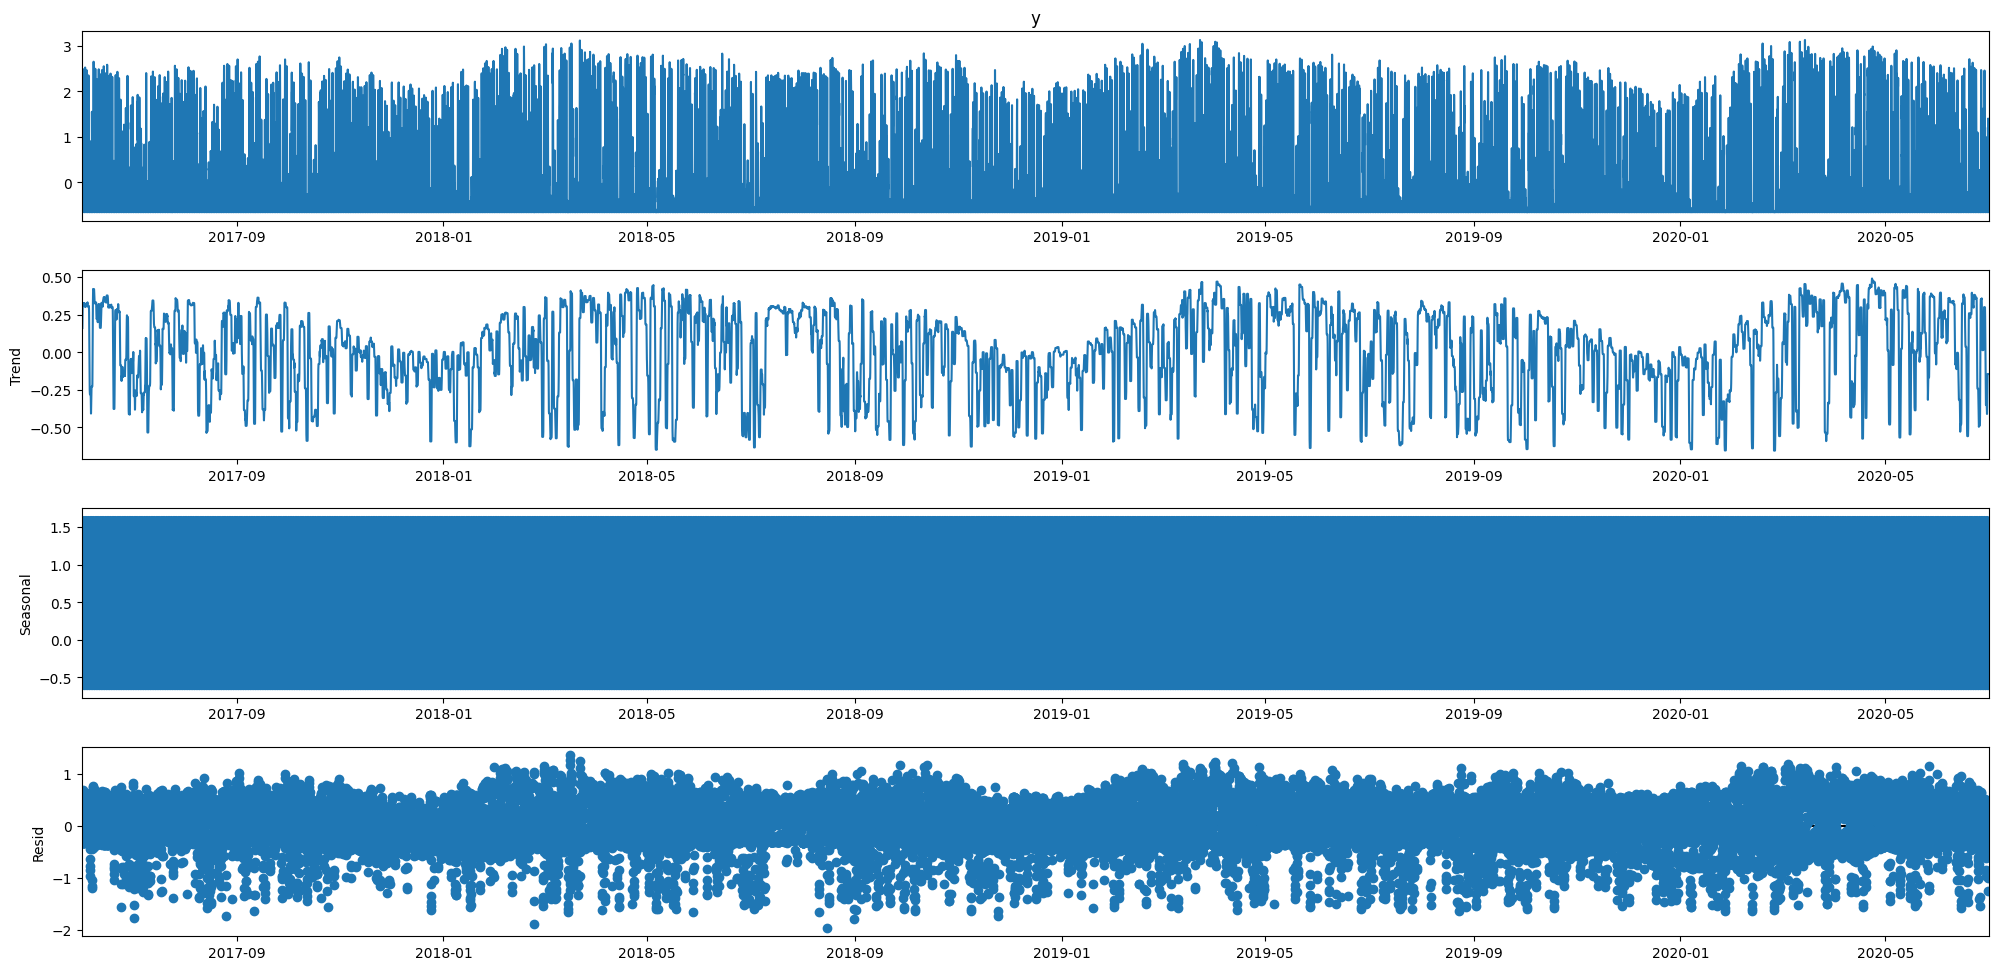

In [13]:
#based on 1hour
decompotion = seasonal_decompose(dataset['y'], model='additive')
fig = decompotion.plot()
fig.set_size_inches(20,10)
plt.show()

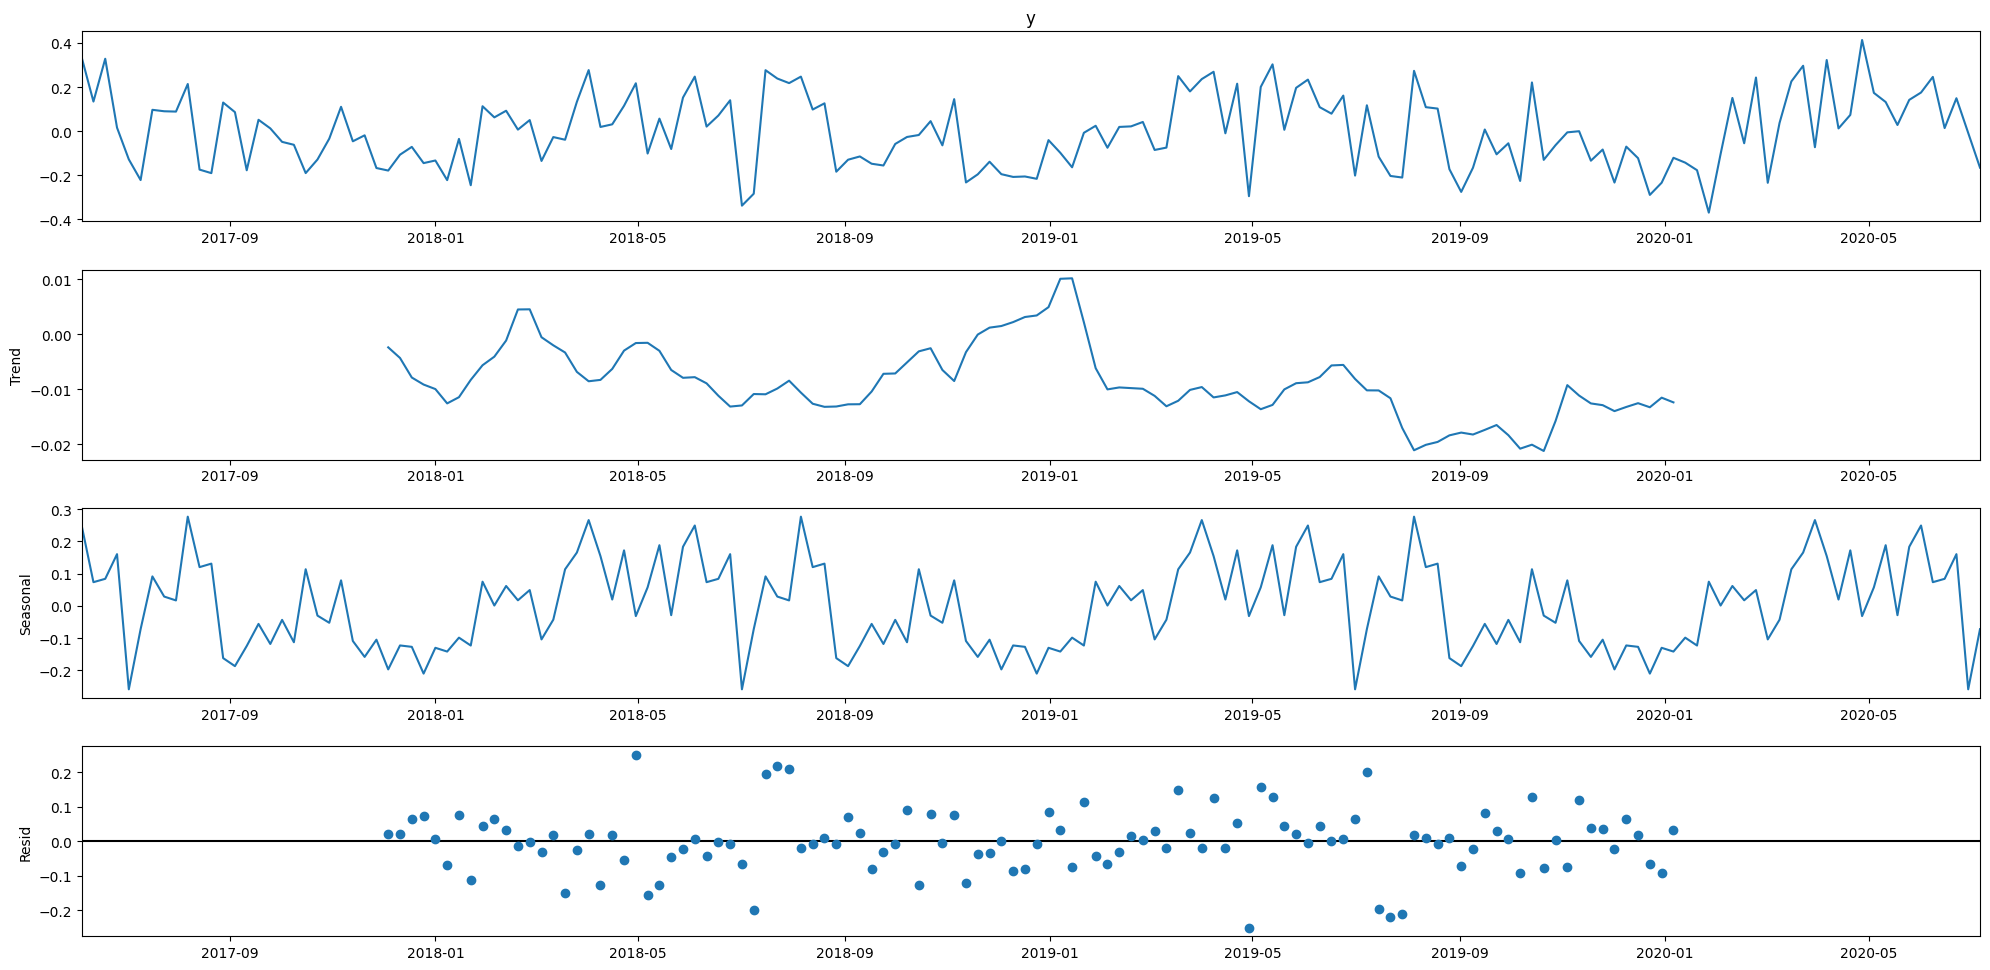

In [14]:
# based on 1 week(only Monday mean)

y = dataset['y'].resample('W-MON').mean()
decompotion = seasonal_decompose(y, model='additive')
fig = decompotion.plot()
fig.set_size_inches(20,10)
plt.show()

## 1.Identify Model to be Tentatively Entertainted

https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html
https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html

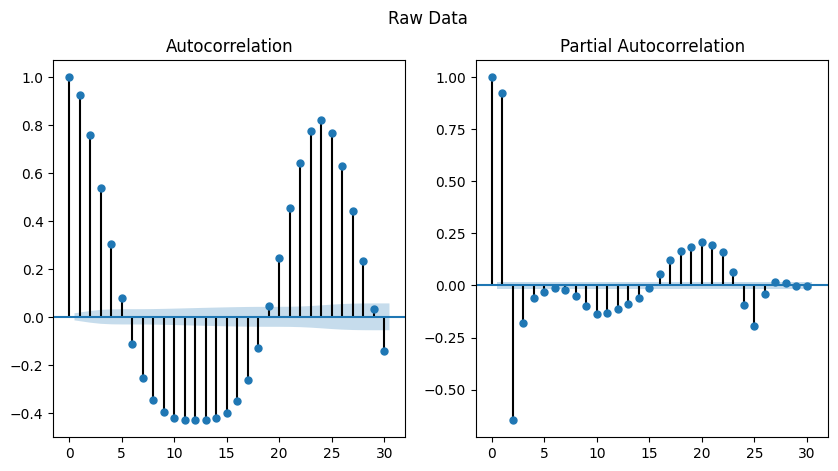

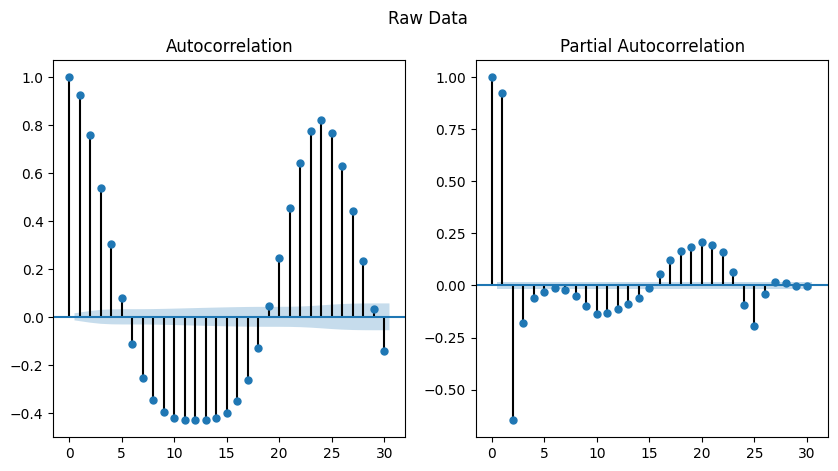

In [15]:
#ACF / PACF plot
fig, ax = plt.subplots(1,2,figsize=(10,5))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(train['y'].values.squeeze(), lags=30, ax=ax[0]) # 스퀴즈(Squeeze) - 1인 차원을 제거한다.
sm.graphics.tsa.plot_pacf(train['y'].values.squeeze(), lags=30, ax=ax[1])

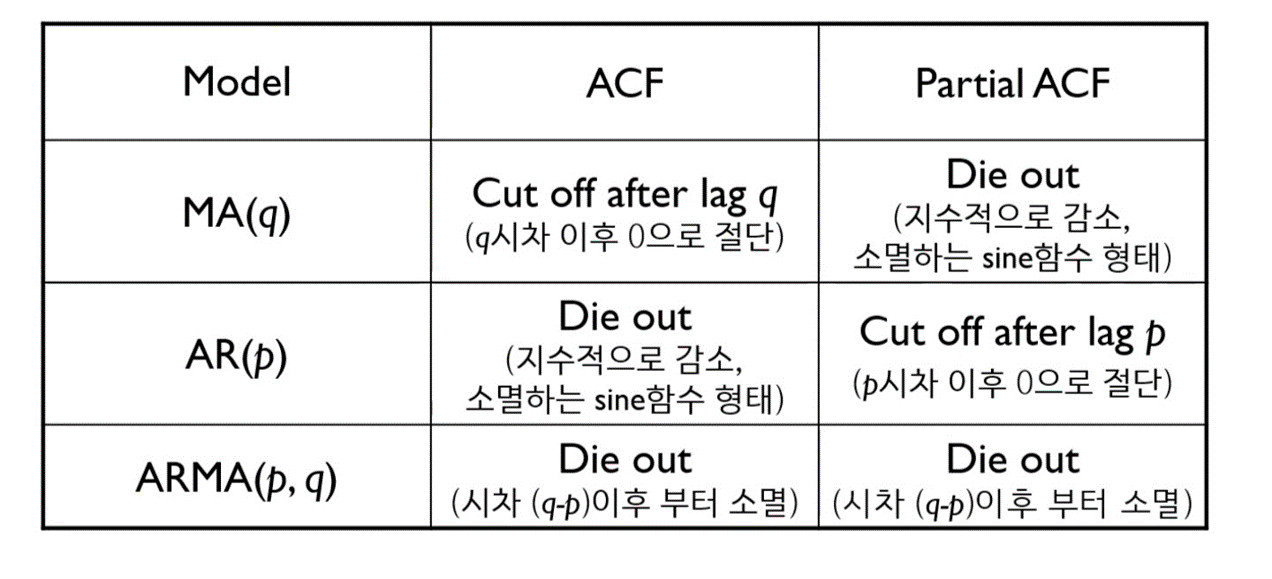

## 2.Estimate parameter

In [17]:
# ARIMA model fitting
# The (p,d,q) order of the model for the number of AR parameters, differences, and MA parameters to use.

model = ARIMA(train['y'].values, order=(1,0,0))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                17511
Model:                     ARMA(1, 0)   Log Likelihood               -8114.840
Method:                       css-mle   S.D. of innovations              0.385
Date:                Tue, 17 Aug 2021   AIC                          16235.679
Time:                        07:46:53   BIC                          16258.991
Sample:                             0   HQIC                         16243.355
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.038     -0.010      0.992      -0.074       0.074
ar.L1.y        0.9230      0.003    317.700      0.000       0.917       0.929
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0834           +0.0000j            1.0834            0.0000
-----------------------------------------------------------------------------
"""

In [20]:
# Parameter search

print('Examples of parameter combination for Seasonal ARIMA')
p = range(0, 3)
d = range(1, 2)
q = range(0, 3)
pdq = list(itertools.product(p,d,q))

aic = []
params=[] # optimal parameter순서 맞추려고 추가함
for i in pdq:
  try:
    model = ARIMA(train['y'].values, order = (i))
    model_fit = model.fit()
    print(f'ARIMA : {i} >> AIC : {round(model_fit.aic, 2)}')
    aic.append(round(model_fit.aic,2))
    params.append(i) # optimal parameter순서 맞추려고 추가함
  except:
    continue

    # order = (2,1,1) 인 경우 계산이 안되어 예외처리함

Examples of parameter combination for Seasonal ARIMA
ARIMA : (0, 1, 0) >> AIC : 16918.32
ARIMA : (0, 1, 1) >> AIC : 11682.57
ARIMA : (0, 1, 2) >> AIC : 10049.25
ARIMA : (1, 1, 0) >> AIC : 9678.86
ARIMA : (1, 1, 1) >> AIC : 9680.86
ARIMA : (1, 1, 2) >> AIC : 10633.39
ARIMA : (2, 1, 0) >> AIC : 9680.86
ARIMA : (2, 1, 2) >> AIC : 6155.67


In [21]:
# Search optimal parameters 

optimal = [(params[i], j) for i, j in enumerate(aic) if j == min(aic)]
optimal

[((2, 1, 2), 6155.67)]

In [22]:
model_opt = ARIMA(train['y'].values, order = optimal[0][0])
model_opt_fit = model_opt.fit()
model_opt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                17510
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -3071.836
Method:                       css-mle   S.D. of innovations              0.288
Date:                Tue, 17 Aug 2021   AIC                           6155.672
Time:                        07:51:30   BIC                           6202.295
Sample:                             1   HQIC                          6171.024
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.242e-06   2.03e-05      0.061      0.951   -3.85e-05     4.1e-05
ar.L1.D.y      1.6899      0.006    261.370      0.000       1.677       1.703
ar.L2.D.y     -0.8038      0.006   -131.801      0.000      -0.816      -0.792
ma.L1.D.y     -1.3064      0.010   -127.475      0.000      -1.326      -1.286
ma.L2.D.y      0.3074      0.010     29.988      0.000       0.287       0.327
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0511           -0.3730j            1.1154           -0.0543
AR.2            1.0511           +0.3730j            1.1154            0.0543
MA.1            1.0015           +0.0000j            1.0015            0.0000
MA.2            3.2485           +0.0000j            3.2485            0.0000
-----------------------------------------------------------------------------
"""

In [32]:
prediction = model_opt_fit.forecast(len(test))
eval_df['ARIMA'] = prediction[0]
eval_df['ARIMA'] = eval_df['ARIMA'].apply(lambda x : x*std+mean)
eval_df

,ds,y,yhat,abs_error,hourly_FA,ARIMA
0,2019-06-01 00:00:00,0.0,7.371081,0.170459,1.259366,5.459079
1,2019-06-01 01:00:00,0.0,8.293482,0.191790,1.291822,13.071309
2,2019-06-01 02:00:00,0.0,10.333848,0.238975,1.363617,21.546970
3,2019-06-01 03:00:00,0.0,10.861808,0.251184,1.382194,29.750945
4,2019-06-01 04:00:00,0.0,8.823412,0.204045,1.310469,36.801737
...,...,...,...,...,...,...
9500,2020-06-30 20:00:00,0.0,39.621030,0.916254,2.394144,34.263521
9501,2020-06-30 21:00:00,0.0,41.901117,0.968982,2.474373,34.263575
9502,2020-06-30 22:00:00,0.0,42.016928,0.971660,2.478448,34.263628
9503,2020-06-30 23:00:00,0.0,40.164727,0.928827,2.413275,34.263682


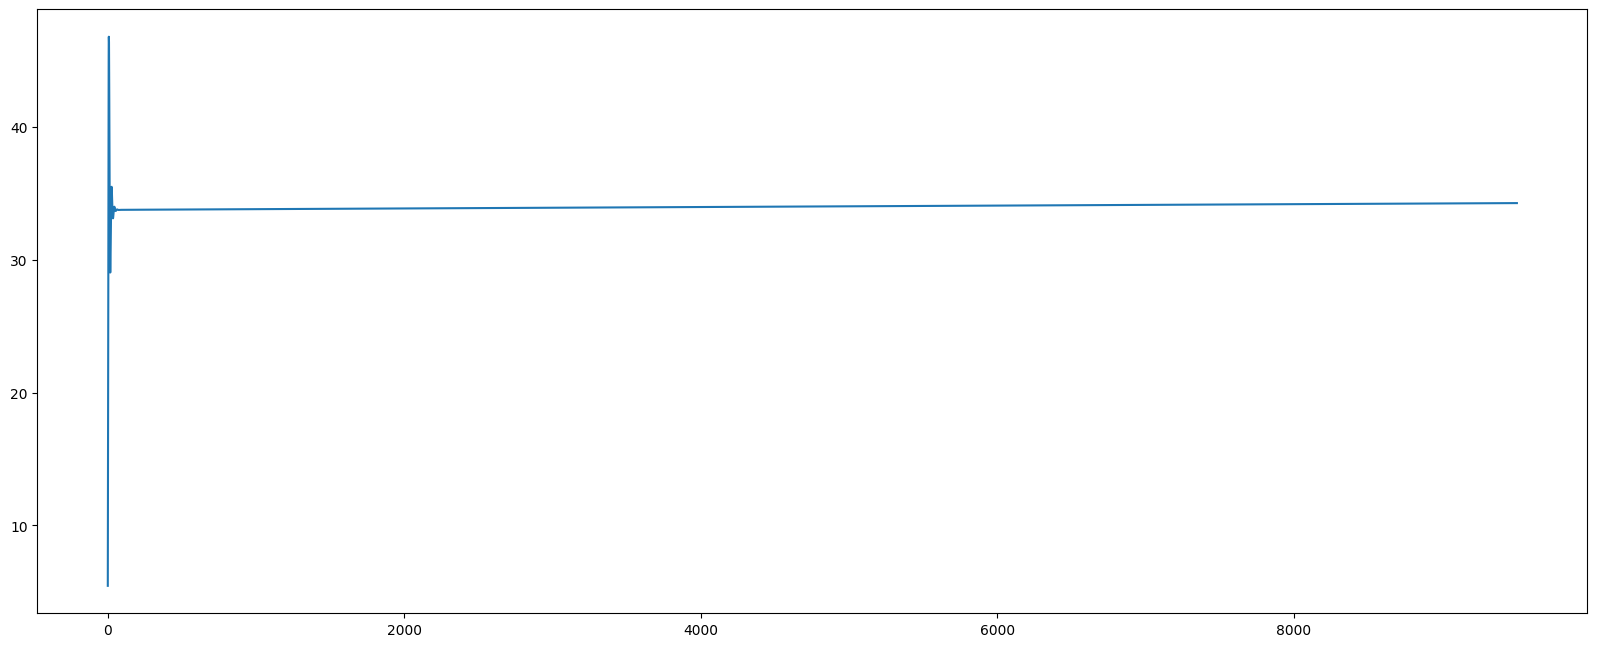

In [33]:
plt.plot(eval_df['ARIMA'])

## 3.SARIMA

In [35]:
model_SARIMA_12 = SARIMAX(train['y'].values, order=(2, 1, 2), seasonal_order=(1,0,0,12))
model_SARIMA_12_fit = model_SARIMA_12.fit()
model_SARIMA_12_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                17511
Model:             SARIMAX(2, 1, 2)x(1, 0, [], 12)   Log Likelihood               -3071.095
Date:                             Tue, 17 Aug 2021   AIC                           6154.189
Time:                                     08:09:30   BIC                           6200.813
Sample:                                          0   HQIC                          6169.542
                                           - 17511                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6867      0.006    276.910      0.000       1.675       1.699
ar.L2         -0.8019      0.006   -134.811      0.000      -0.814      -0.790
ma.L1         -1.3022      0.008   -161.763      0.000      -1.318      -1.286
ma.L2          0.3032      0.008     37.753      0.000       0.287       0.319
ar.S.L12      -0.0109      0.019     -0.590      0.555      -0.047       0.025
sigma2         0.0831      0.000    172.539      0.000       0.082       0.084
===================================================================================
Ljung-Box (L1) (Q):                   0.43   Jarque-Bera (JB):             43678.08
Prob(Q):                              0.51   Prob(JB):                         0.00
Heteroskedasticity (H):               0.90   Skew:                             0.91
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [37]:
model_SARIMA = SARIMAX(train['y'].values, order=(2, 1, 2), seasonal_order=(1,0,0,24)) # SARIMA 태양광 예측 parameter 기준
model_SARIMA_fit = model_SARIMA.fit()
model_SARIMA_fit.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                17511
Model:             SARIMAX(2, 1, 2)x(1, 0, [], 24)   Log Likelihood               -1748.158
Date:                             Tue, 17 Aug 2021   AIC                           3508.317
Time:                                     08:17:38   BIC                           3554.940
Sample:                                          0   HQIC                          3523.669
                                           - 17511                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6625      0.009    181.955      0.000       1.645       1.680
ar.L2         -0.7654      0.009    -88.823      0.000      -0.782      -0.749
ma.L1         -1.4982      0.011   -134.758      0.000      -1.520      -1.476
ma.L2          0.4987      0.011     44.901      0.000       0.477       0.520
ar.S.L24       0.4392      0.004    103.505      0.000       0.431       0.448
sigma2         0.0714      0.000    192.406      0.000       0.071       0.072
===================================================================================
Ljung-Box (L1) (Q):                   3.22   Jarque-Bera (JB):             55915.75
Prob(Q):                              0.07   Prob(JB):                         0.00
Heteroskedasticity (H):               0.89   Skew:                             0.82
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [39]:
prediction_SARIMA = model_SARIMA_fit.forecast(len(test))
eval_df['SARIMA'] = prediction_SARIMA[0]
eval_df['SARIMA'] = eval_df['SARIMA'].apply(lambda x : x*std+mean)
eval_df

,ds,y,yhat,abs_error,hourly_FA,ARIMA,SARIMA
0,2019-06-01 00:00:00,0.0,7.371081,0.170459,1.259366,5.459079,3.27668
1,2019-06-01 01:00:00,0.0,8.293482,0.191790,1.291822,13.071309,3.27668
2,2019-06-01 02:00:00,0.0,10.333848,0.238975,1.363617,21.546970,3.27668
3,2019-06-01 03:00:00,0.0,10.861808,0.251184,1.382194,29.750945,3.27668
4,2019-06-01 04:00:00,0.0,8.823412,0.204045,1.310469,36.801737,3.27668
...,...,...,...,...,...,...,...
9500,2020-06-30 20:00:00,0.0,39.621030,0.916254,2.394144,34.263521,3.27668
9501,2020-06-30 21:00:00,0.0,41.901117,0.968982,2.474373,34.263575,3.27668
9502,2020-06-30 22:00:00,0.0,42.016928,0.971660,2.478448,34.263628,3.27668
9503,2020-06-30 23:00:00,0.0,40.164727,0.928827,2.413275,34.263682,3.27668


In [44]:
import plotly.graph_objects as go

resample = eval_df[eval_df['ds'] >= '2020-05-01']

f = go.FigureWidget()

f.update_layout(plot_bgcolor='white')
f.add_scatter(y=eval_df['y'],x = eval_df['ds'], name = 'Real result');
f.add_scatter(y=eval_df['yhat'],x = eval_df['ds'], name = 'Prophet prediction');
f.add_scatter(y=eval_df['ARIMA'],x = eval_df['ds'], name = 'ARIMA');
f.add_scatter(y=eval_df['SARIMA'],x = eval_df['ds'], name = 'SARIMA');
f.show()